In [1]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-20", end="2019-05-21")

[*********************100%***********************]  20 of 20 completed


In [3]:
returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
returns = returns.stack()
returns

date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [4]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [5]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [6]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [7]:
# 10-day Momentum

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [8]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# %%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

# %%time
df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (6 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (6 days old).
- Loading from disk ... Done!


In [9]:
# Price to book value
df_pbv = pd.DataFrame()
for i in tickers:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pbv = df_pbv.stack()
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [10]:
# Market Cap
df_mc = pd.DataFrame()
for i in tickers:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [11]:
# P/E
df_pe = pd.DataFrame()
for i in tickers:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [12]:
from datetime import datetime

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

#df_original = pd.DataFrame.from_dict(data)
#df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor","Momentum","Price to book Value","Market Cap"], inplace=True)
df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810748,4.168957,0.481235,-0.585197,-0.658513,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173145,-0.364517,0.269450,0.889325,0.762768,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868855,-0.175676,1.211605,-1.113785,-1.318079,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147891,-0.182383,0.935859,-0.865218,-0.668475,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070578,-0.362698,0.926078,-0.218245,-0.054706,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380690,0.981545,2.885535,-3.115083,-3.223191,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996915,-0.306641,1.326232,-1.656099,-1.652367,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220526,-0.344192,-0.781094,0.387177,0.001531,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744173,-0.125277,-0.862245,0.519055,0.443085,-0.244783,0.371986,-0.069833


In [13]:
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==len(tickers):
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [14]:
np.array(tensor)

array([[[-8.10748492e-01,  4.16895682e+00,  4.81234908e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73145036e-01, -3.64517363e-01,  2.69449957e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68855097e-01, -1.75675935e-01,  1.21160491e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16963943e-01, -1.75317019e-01,  2.72517890e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59119418e-01, -2.64450151e-01,  2.43231469e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32721936e-01, -3.62254159e-01,  2.42414348e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54432784e-01,  4.78699168e+00,  6.93646109e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28184802e+00, -3.59660481e-01,  3.48496285e-01, ...,
         -3.42813725e-01, -7.33077090e

In [15]:
from corcondia import corcondia_3d
print(corcondia_3d(np.array(tensor), k=3))

-480.0661419102055


In [16]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [17]:
alg = HOSVD()
alg

HOSVD(process=(), verbose=False)

In [18]:
ml_rank = (2010, 19, 3)
tensor_tkd_hosvd = alg.decompose(tensor_data, ml_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_tkd_hosvd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd_hosvd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd_hosvd.core)
tensor_tkd_hosvd.core.data

	Output of the HOSVD algorithm:
Tucker representation of a tensor with multi-linear rank=(2010, 19, 3).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 19)
Mode-2 factor matrix is of shape (8, 3)

	Core tensor
This tensor is of order 3 and consists of 114570 elements.
Sizes and names of its modes are (2010, 19, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


array([[[-8.41638873e+00, -2.38557172e+00, -2.70558541e+01],
        [ 2.70338784e+00,  1.99533166e+02,  2.52879939e+01],
        [ 8.95282161e+00,  4.08788666e+01,  3.15567445e+01],
        ...,
        [-4.02549396e+00,  3.63862975e+00,  1.09434660e+00],
        [ 3.04167874e+00, -4.03384052e-02,  2.14451969e+00],
        [ 2.43256895e-02, -2.08754340e+00, -2.54295614e+00]],

       [[-7.99672768e+00,  8.48306877e+00, -3.57299384e+01],
        [ 5.78811199e+00,  2.51329418e+01, -4.73741808e+01],
        [-1.69305138e+00, -5.96801424e+00,  1.16173832e+02],
        ...,
        [ 6.17797010e-01, -4.25199182e-01, -1.61068510e-01],
        [ 3.87667185e-02,  3.18772764e-01, -2.22184216e-01],
        [ 1.16291119e+00, -1.72421285e-01,  5.79978554e-01]],

       [[ 1.78667221e+02, -4.72455581e+00, -2.42209919e+00],
        [-2.31700926e+01,  7.96372374e+00,  2.11080108e+00],
        [ 4.59284329e+01,  1.64556834e+01,  5.91785750e+00],
        ...,
        [ 8.06879256e-01, -5.58314450e-01,

In [19]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_tkd_hosvd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_tkd_hosvd.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 19)
Mode-2 factor matrix is of shape (8, 3)


[array([[-1.87328442e-02, -2.70003333e-03, -2.06385852e-02, ...,
          2.47669938e-02,  2.89143815e-02,  7.97274074e-03],
        [-2.01744511e-02, -3.06262178e-03, -2.87871744e-02, ...,
          1.13601169e-02,  2.28270052e-04,  1.50886033e-02],
        [-1.80226070e-02, -3.42531995e-03, -2.25517919e-02, ...,
          4.79641883e-02,  4.51904901e-02,  3.37967294e-02],
        ...,
        [-2.42976102e-02, -6.06810110e-03, -2.20876416e-02, ...,
         -8.44043429e-02,  8.77787216e-01, -8.71675623e-02],
        [-2.52324899e-02, -7.49466457e-03, -1.28374897e-02, ...,
         -8.02531474e-02, -9.02152210e-02,  8.21854470e-01],
        [-2.46536552e-02, -7.88928921e-03, -2.30887670e-02, ...,
         -7.66811256e-02, -9.47859258e-02, -1.34768894e-01]]),
 array([[ 1.70386264e-01,  8.26751068e-01,  4.27099905e-01,
          9.74710597e-02,  8.50542614e-03, -1.04743704e-01,
          2.17318939e-01, -1.24842743e-01,  3.12170915e-02,
          2.01188181e-02, -6.94117497e-02,  1.467

In [20]:
index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
# index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_tkd_hosvd.fmat[1], columns = [i for i in range(tensor_tkd_hosvd.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AAPL,0.170386,0.826751,0.427100,0.097471,0.008505,-0.104744,0.217319,-0.124843,0.031217,0.020119,-0.069412,0.014677,0.008168,-0.112614,-0.009475,-0.001478,-0.042505,0.004684,0.022086
ADBE,0.168719,-0.094625,0.021542,-0.080188,0.016361,0.155999,0.011331,-0.105091,0.071641,0.005445,-0.151629,-0.068042,0.688569,-0.303630,0.398705,0.082373,-0.017173,0.387506,-0.053371
AMAT,0.194289,-0.112496,0.103365,-0.154471,-0.045438,0.209409,0.168541,-0.103512,0.117982,0.048657,-0.422361,-0.223486,-0.153962,0.169136,0.101425,-0.686203,0.102239,-0.049292,-0.159157
AMD,0.444615,-0.205278,0.280329,-0.332823,-0.104403,-0.694113,-0.174128,0.180883,-0.095556,0.025961,-0.005438,-0.061361,-0.001852,0.013115,0.028027,0.019636,-0.006070,-0.006625,-0.007995
AMZN,0.447897,0.256037,-0.806474,-0.037886,-0.110872,-0.131088,0.221725,-0.003877,-0.036370,0.007405,-0.004723,0.011496,-0.036261,0.001455,0.020014,0.001140,0.003582,0.006017,-0.004504
CSCO,0.137697,0.008208,0.083263,-0.109912,-0.053045,0.210575,0.059895,0.066260,-0.382911,-0.851621,0.144608,-0.096019,-0.040626,-0.030998,0.031782,-0.027631,-0.000923,-0.005483,0.003743
GOOGL,0.175547,0.177727,-0.055643,-0.072069,0.010327,0.302725,-0.592684,0.220207,0.065588,0.121478,0.023074,-0.376575,-0.247037,-0.272857,-0.013290,-0.004287,-0.369949,0.059454,-0.008406
HPQ,0.117482,-0.066134,0.157697,-0.159544,-0.193869,0.321270,0.466462,0.507972,-0.161681,0.361506,0.343688,-0.120864,0.015539,-0.063222,-0.040400,0.071764,0.112044,-0.006823,0.021857
IBM,0.083656,-0.038423,0.007799,-0.046295,-0.035716,0.059541,-0.016307,0.065252,-0.096009,0.010503,-0.012076,0.419382,0.298395,-0.035465,-0.618568,-0.329184,-0.423427,0.166600,0.015634
INTC,0.120588,0.019750,0.075570,-0.108617,-0.066248,0.188787,0.021611,0.026574,-0.011198,0.035387,-0.122031,0.242681,-0.000444,0.572557,0.319005,0.318585,-0.491822,-0.136297,-0.231369


## PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([-0.0090589 , -0.16471529,  0.28290773, -0.63813041,  0.28703763,
       -0.09192605,  0.11636036,  0.12348226, -0.06542427,  0.20303683,
        0.00223486, -0.01653112, -0.02330234,  0.24609372,  0.01953782,
        0.35666304, -0.28245329,  0.04302536, -0.21440661, -0.06190181])

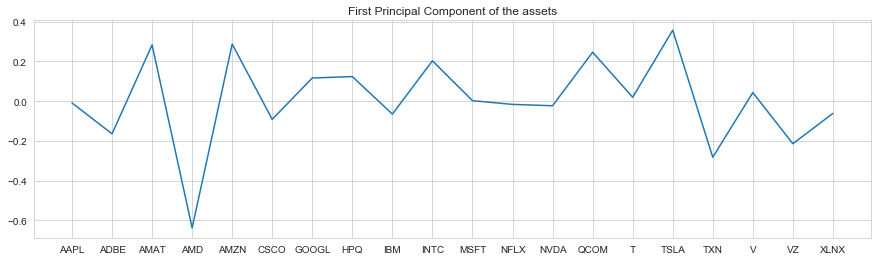

In [22]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets')
fig.set_size_inches(15, 4) 

In [23]:
pc1.sort_values()

AMD     -0.638130
TXN     -0.282453
VZ      -0.214407
ADBE    -0.164715
CSCO    -0.091926
IBM     -0.065424
XLNX    -0.061902
NVDA    -0.023302
NFLX    -0.016531
AAPL    -0.009059
MSFT     0.002235
T        0.019538
V        0.043025
GOOGL    0.116360
HPQ      0.123482
INTC     0.203037
QCOM     0.246094
AMAT     0.282908
AMZN     0.287038
TSLA     0.356663
dtype: float64

In [24]:
dominant_assets = pc1.sort_values().index[-10:]
dominant_assets = " ".join(dominant_assets)
dominant_assets

'MSFT T V GOOGL HPQ INTC QCOM AMAT AMZN TSLA'

## ICA

In [25]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


[*********************100%***********************]  20 of 20 completed


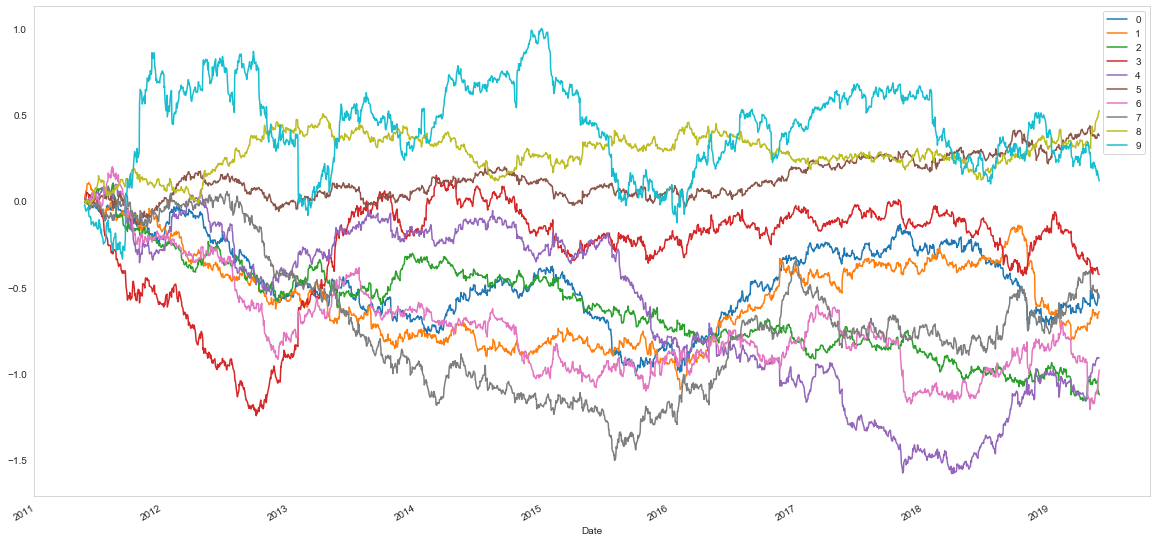

In [26]:
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(abs(ica.components_[i])/sum(abs(ica.components_[i]))).cumsum().plot(ax=ax)
ax.legend([str(i) for i in range(10)])
ax.grid()

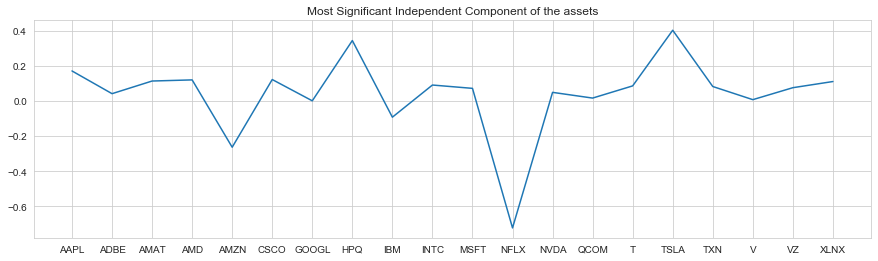

In [27]:
fig, axes = plt.subplots(1)
ic1 = pd.Series(index=index, data=ica.components_[9])
ic1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='Most Significant Independent Component of the assets')
fig.set_size_inches(15, 4) 

In [28]:
ic1.sort_values()

NFLX    -0.723145
AMZN    -0.263946
IBM     -0.092985
GOOGL    0.000153
V        0.006759
QCOM     0.015725
ADBE     0.040823
NVDA     0.048271
MSFT     0.071053
VZ       0.074819
TXN      0.081598
T        0.085112
INTC     0.089986
XLNX     0.109887
AMAT     0.112775
AMD      0.119224
CSCO     0.121320
AAPL     0.170080
HPQ      0.343133
TSLA     0.401768
dtype: float64

In [29]:
num_assets = len(ica.components_[0])//2
dominant_assets_ica = ic1.sort_values().index[-num_assets:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'TXN T INTC XLNX AMAT AMD CSCO AAPL HPQ TSLA'

# Testing

## PCA

In [30]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AMAT     0.022545
            AMZN    -0.000780
            GOOGL    0.008508
            HPQ      0.025001
            INTC     0.020450
                       ...   
2021-05-19  MSFT     0.002471
            QCOM     0.013484
            T       -0.020168
            TSLA    -0.025253
            V       -0.004354
Length: 5040, dtype: float64

In [31]:
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
mean_returns

[0.01035669437852893,
 -0.020709186636047327,
 -0.006930703730413867,
 -0.001312703322710096,
 -0.007341153172941528,
 -0.004099772631453469,
 0.0036707624790547565,
 -0.0182471353654551,
 -0.01911856971816168,
 0.03146494273452323,
 0.005309277957640868,
 0.014176114907611037,
 0.014084177677883326,
 0.017092515107294613,
 0.005059910020073444,
 -0.01226390549078209,
 0.005772113551598101,
 -0.0037866173712418406,
 0.004851446934567738,
 0.01783825385612179,
 0.002396240186624343,
 0.0055671848911647,
 0.0004998617549211825,
 0.0006772742652483732,
 -0.014670804859995413,
 0.011060214367003374,
 0.004635780508930853,
 0.005523723060497687,
 0.01090173490151014,
 0.0008152244029617783,
 0.008465197427067129,
 -0.001610931678965244,
 -0.006403742543623992,
 0.0026907420553833996,
 0.008805514515875013,
 0.002057127860852992,
 0.012752163704642916,
 0.005807828611361953,
 -0.00551120721553211,
 -0.0017301487815356343,
 0.003505240982717739,
 -0.0009248864486516961,
 0.010338631619465844,

In [32]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

HOSVD+PCA


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,38.18%
Cumulative returns,90.937%
Annual volatility,31.937%
Sharpe ratio,1.18
Calmar ratio,1.06
Stability,0.88
Max drawdown,-36.12%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.12,2020-02-19,2020-03-20,2020-08-18,130
1,11.75,2020-09-02,2020-09-23,2020-11-19,57
2,9.05,2019-07-24,2019-08-23,2019-10-24,67
3,8.70,2021-04-26,2021-05-12,NaT,NaN
4,7.20,2019-05-21,2019-06-03,2019-06-10,15


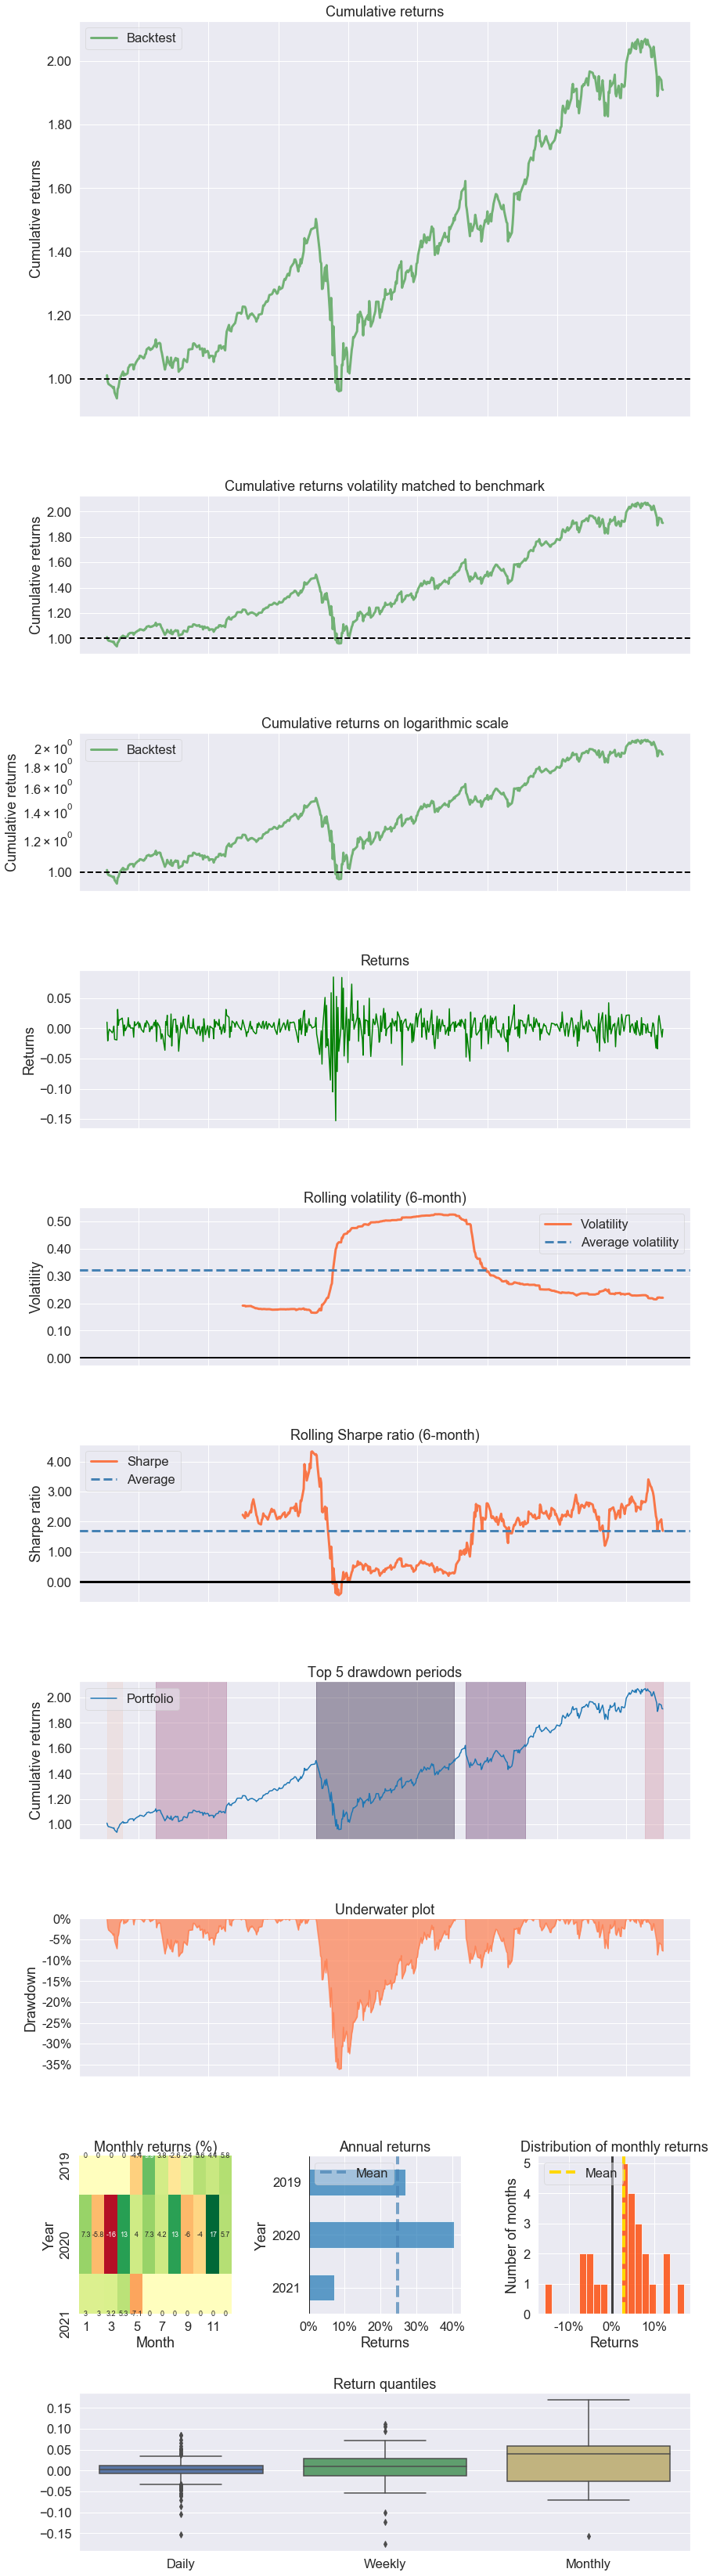

In [33]:
import pyfolio as pf
print("HOSVD+PCA")
pf.create_returns_tear_sheet(df)

## ICA

In [34]:
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            AMAT     0.022545
            AMD      0.024802
            CSCO     0.009064
            HPQ      0.025001
                       ...   
2021-05-19  INTC     0.009437
            T       -0.020168
            TSLA    -0.025253
            TXN      0.015808
            XLNX     0.024732
Length: 5040, dtype: float64

In [35]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.01930246953619421,
 -0.01479718479587273,
 -0.010796399753868525,
 -0.00039919292467986977,
 -0.0005652282764260441,
 -0.0028755527974355655,
 0.00578132566029863,
 -0.02351202525510785,
 -0.003014949285491264,
 0.04150536243393166,
 0.006207107807895529,
 0.02033205133834226,
 0.011340962672704702,
 0.017697385947005186,
 0.005587637429503145,
 -0.01853763969159137,
 0.003252442098504149,
 -0.014765985358028555,
 -0.0010443014532402818,
 0.028753142499206952,
 0.0013760952269165293,
 0.00556797889720233,
 -0.006782885514572623,
 0.0014497036183903412,
 -0.0130374790187763,
 0.020294491497313105,
 0.009502896025171426,
 -0.0016470390079345253,
 0.013769983807381436,
 -0.003015981651788513,
 0.007592773595253855,
 -0.0015913542940578563,
 -0.007072739042927356,
 0.0060214307638820855,
 0.012045147724867755,
 0.0004752875234686371,
 0.015753487564195544,
 0.011006797949605573,
 -0.00751500588327767,
 -0.0032453429500412857,
 0.00817692236557277,
 -0.004043501077832579,
 0.011244810936

In [36]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

HOSVD+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,37.57%
Cumulative returns,89.254%
Annual volatility,33.91%
Sharpe ratio,1.11
Calmar ratio,1.05
Stability,0.85
Max drawdown,-35.903%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.90,2020-02-19,2020-03-20,2020-08-12,126
1,13.26,2019-07-24,2019-08-23,2019-11-05,75
2,11.60,2020-09-02,2020-09-23,2020-11-17,55
3,10.96,2021-02-12,2021-03-08,2021-04-05,37
4,9.33,2021-04-26,2021-05-12,NaT,NaN


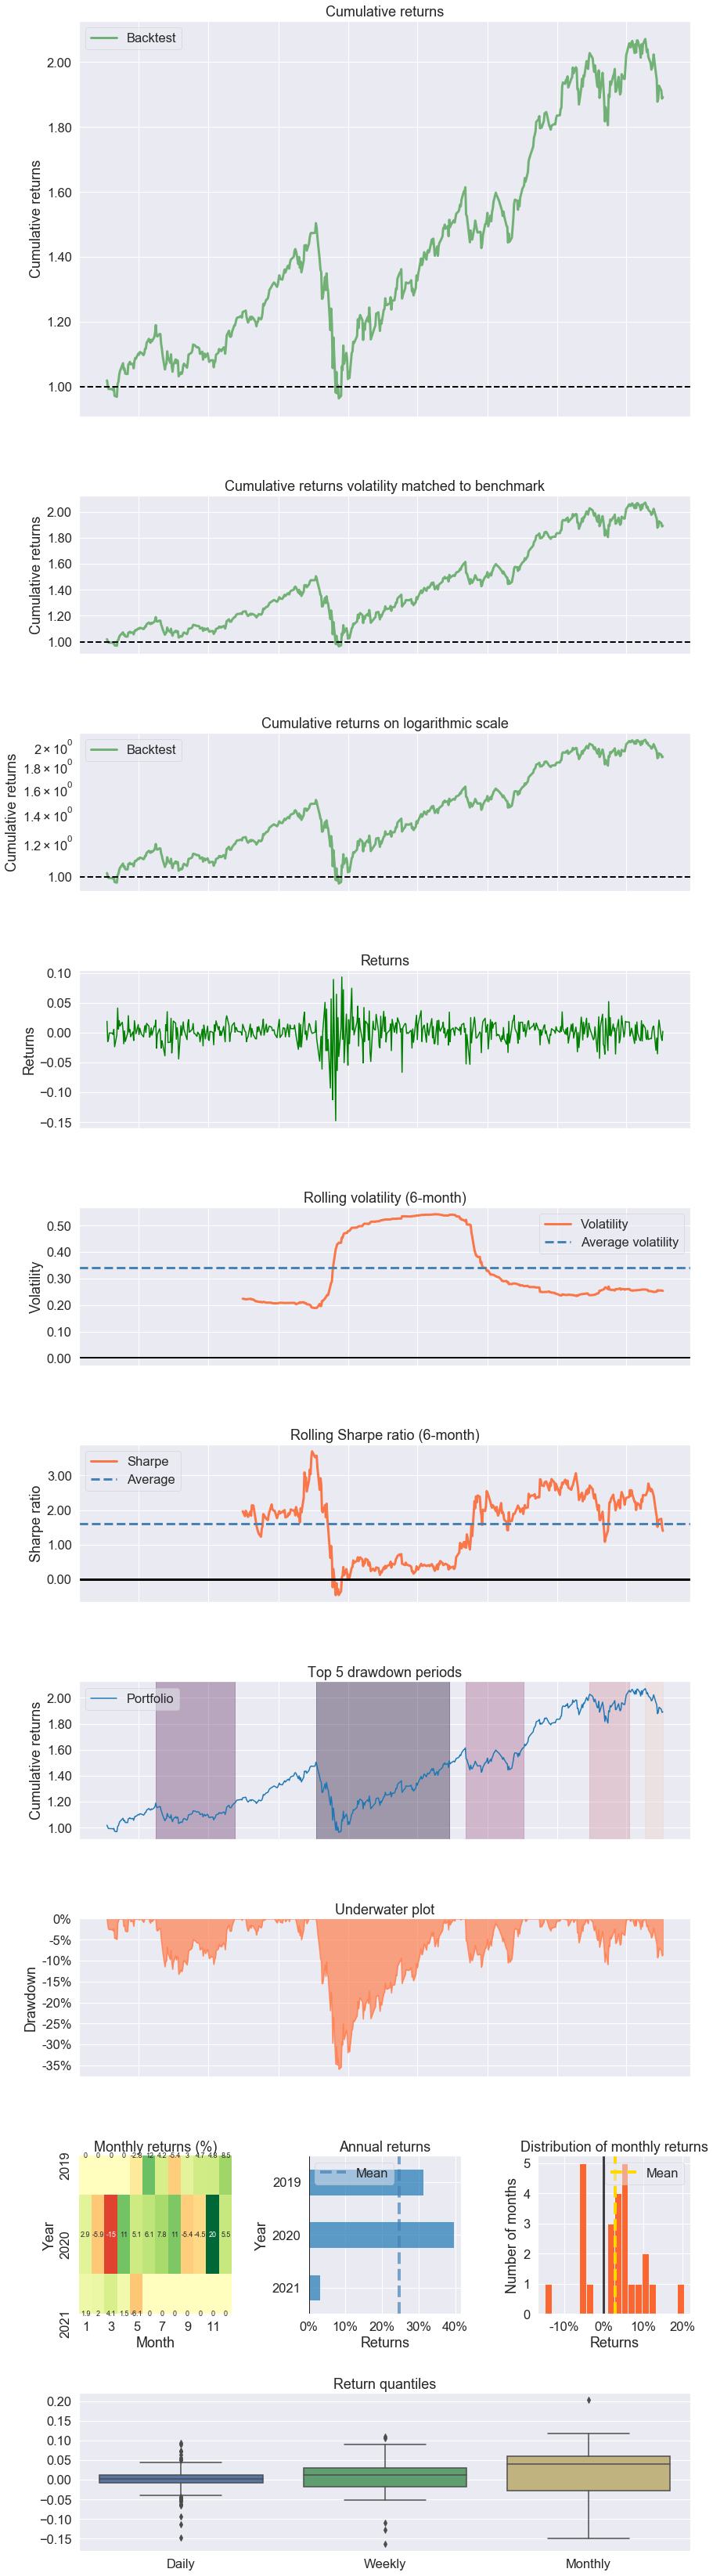

In [37]:
import pyfolio as pf
print("HOSVD+ICA")
pf.create_returns_tear_sheet(df)